## AIS Validation
* Combine all vessels data and Remove any invalid MMSI entries
* Scrub Broadcast and Voyage Data based on valid vessels
* Combine Broadcast and Voyage Data by Year
* Output consolidated files

In [1]:
# from IPython.display import Image, HTML
import os
import numpy as np
import pandas as pd
import datetime
import warnings
from glob import glob

warnings.filterwarnings("ignore")           # Suppress Warning

In [2]:
# s3://vault-data-corpus/vessel data/Cleaned AIS/
WorkingFolder = "data/vessel data/Cleaned AIS/"

In [3]:
# s3://vault-data-corpus/vessel data/ValidAIS/
OutputDir = "data/vessel data/ValidAIS/"

### Combining Vessels Data

In [18]:
# Combining all Vessels Data
df_list = list()

for folder in glob(WorkingFolder + "*/"):
    
#     #******** Temp hack for testing
#     folder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone03_2017_01/"
#     #************
    
    print(folder)
    df = pd.read_csv(folder + "Vessel.csv", sep=",")
    
    print("Rows:", len(df))
    
    df_list.append(df)
    
#     break
    
Vessel = pd.concat(df_list, ignore_index=True)
print("Total Rows:", Vessel.shape)

# Remove duplicate vessel records after combining all the zones/years
Vessel.drop_duplicates(inplace=True)

print("Non-Dup Total Rows:", Vessel.shape)
# Vessel.reset_index(inplace=True)

/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone03_2015_01/
Rows: 849
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone02_2015_01/
Rows: 612
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2011_01/
Rows: 2035
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2010_01/
Rows: 1964
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2014_01/
Rows: 2334
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2015_01/
Rows: 143
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2013_01/
Rows: 1927
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2016_01/
Rows: 48
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2017_01/
Rows: 58
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2012_01/
Rows: 1971
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2009_01/
Rows: 1972
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zo

In [19]:
Vessel.shape

(10658, 7)

In [20]:
Vessel.head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width
0,303159000,IMO8315724,WAP2210,ARCTURUS,1001.0,39.93,9.76
1,367011410,IMO8856510,WAJ6882,KUSTATAN,1001.0,26.76,8.53
2,366499000,IMO6931055,WASF,KATIE ANN,1001.0,89.92,13.52
3,367528690,IMO7742358,WDG3692,ALASKAN LADY,1001.0,51.08,9.76
4,371542000,IMO8714944,3FSS6,NO1 POHAH,70.0,115.00,16.00


In [21]:
Vessel.tail()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width
16376,1033360095,NaN,NaN,NaN,NaN,NaN,NaN
16377,338982000,IMO8835229,AAHK,USAV WORTHY,1018.0,68.28,13.1
16378,370078000,NaN,NaN,NaN,NaN,NaN,NaN
16379,159011837,NaN,NaN,NaN,NaN,NaN,NaN
16380,366588908,NaN,NaN,NaN,NaN,NaN,NaN


### Validate MMSI Id

In [22]:
# Cast MMSI Id field to string
Vessel['TempId'] = Vessel['mmsi_id'].map(lambda x: str(x))
# Fetch the field lengh (number of digits)
Vessel['Id_len'] = Vessel['TempId'].map(lambda x: len(x))
# Fetch starting digit 
Vessel['StartDigit'] = Vessel['TempId'].map(lambda x: int(x[0]))

df.head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width
0,366993150,IMO7933579,WDI5834,SAGA,1001.0,28.75,9.15
1,366182680,NaN,WDD3084,BRENNA A,30.0,35.00,10.00
2,374275000,IMO9722455,3FAO8,IYO SEA,1004.0,179.97,NaN
3,367098030,IMO8852667,WBS9245,KONA KAI,1001.0,24.26,7.92
4,432567899,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# MMSI Id NOT 9 digits
Vessel.loc[Vessel['Id_len'] != 9].head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width,TempId,Id_len,StartDigit
317,43676060,IMO0964016,WCD8162,SILVER SPRAY,0.0,32.0,9.0,43676060,8,4
718,32767,NaN,NaN,NaN,NaN,NaN,NaN,32767,5,3
1070,1073502465,NaN,NaN,NaN,NaN,NaN,NaN,1073502465,10,1
1278,1009252285,NaN,NaN,NaN,NaN,NaN,NaN,1009252285,10,1
1748,12348576,NaN,NaN,NaN,0.0,0.0,0.0,12348576,8,1


In [24]:
# Purge - MMSI Id NOT 9 digits
Vessel = Vessel.loc[Vessel['Id_len'] == 9]
print("Remaining Rows:", Vessel.shape)

Remaining Rows: (10397, 10)


In [25]:
# MMSI Id starting digit NOT from 2 to 7
Vessel.loc[(Vessel['StartDigit'] < 2) | (Vessel['StartDigit'] > 7)].head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width,TempId,Id_len,StartDigit
103,970113380,NaN,NaN,NaN,NaN,NaN,NaN,970113380,9,9
104,970113086,NaN,NaN,NaN,NaN,NaN,NaN,970113086,9,9
330,972122919,NaN,NaN,NaN,NaN,NaN,NaN,972122919,9,9
332,972122997,NaN,NaN,NaN,NaN,NaN,NaN,972122997,9,9
369,972122921,NaN,NaN,NaN,NaN,NaN,NaN,972122921,9,9


In [26]:
# Purge - MMSI Id starting digit NOT from 2 to 7
Vessel = Vessel.loc[(Vessel['StartDigit'] > 1) & (Vessel['StartDigit'] < 8)]
print("Remaining Rows:", Vessel.shape)

Remaining Rows: (10245, 10)


In [27]:
# Duplicate MMSI Id
df = Vessel.groupby(['mmsi_id']).size().reset_index(name='counts')
df.sort_values(by=['counts'], ascending=False).head()

,mmsi_id,counts
4721,367098250,5
3788,366360509,5
5491,367740200,5
7833,563020027,5
3166,355007701,5


In [32]:
print("Duplicate MMSI:", df.loc[df.counts > 1].shape)

Duplicate MMSI: (1183, 2)


In [33]:
Vessel.loc[Vessel['mmsi_id'] == 367098250]

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width,TempId,Id_len,StartDigit
3685,367098250,NaN,NaN,NaN,30.0,30.0,10.0,367098250,9,3
5943,367098250,NaN,NaN,NaN,30.0,28.0,11.0,367098250,9,3
10695,367098250,NaN,NaN,NaN,30.0,30.0,12.0,367098250,9,3
13567,367098250,7110866,WDC1950,NEW ENGLAND COAST,52.0,0.0,0.0,367098250,9,3
13596,367098250,711086600,WCW6137,NEWENGLAND COAST,35.0,0.0,0.0,367098250,9,3


In [34]:
Vessel.drop_duplicates("mmsi_id", inplace=True)
print("Remaining Rows:", df.shape)

Remaining Rows: (8817, 2)


In [35]:
Vessel.head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width,TempId,Id_len,StartDigit
0,303159000,IMO8315724,WAP2210,ARCTURUS,1001.0,39.93,9.76,303159000,9,3
1,367011410,IMO8856510,WAJ6882,KUSTATAN,1001.0,26.76,8.53,367011410,9,3
2,366499000,IMO6931055,WASF,KATIE ANN,1001.0,89.92,13.52,366499000,9,3
3,367528690,IMO7742358,WDG3692,ALASKAN LADY,1001.0,51.08,9.76,367528690,9,3
4,371542000,IMO8714944,3FSS6,NO1 POHAH,70.0,115.00,16.00,371542000,9,3


In [38]:
# Save valid Vessels to csv
Vessel.to_csv(OutputDir + "Valid_Vessels.csv", index=False)

### Purge Broadcasts for Invalid MMSI

In [107]:
folder = WorkingFolder + "Zone03_2016_01/"
outputfile = "data/vessel data/ValidAIS/Broadcast_Zone03_2016_01.csv"

Broadcast = pd.read_csv(folder + "Broadcast.csv", sep=",")
Broadcast.head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
0,366993150,2016-01-01T00:01:17,53.90715,-166.51023,0.0,-143.5,NaN,199.0,undefined
1,366182680,2016-01-01T00:02:26,53.94988,-166.48963,0.3,-74.5,NaN,511.0,under way using engine
2,366993150,2016-01-01T00:02:27,53.90713,-166.51027,0.0,-151.6,NaN,200.0,undefined
3,366993150,2016-01-01T00:05:57,53.90713,-166.51027,0.0,-176.1,NaN,199.0,undefined
4,366993150,2016-01-01T00:13:58,53.90713,-166.51027,0.0,-173.5,NaN,199.0,undefined


In [108]:
print("Raw Count:", Broadcast.shape[0])

Raw Count: 2575263


In [109]:
# Purge any Broadcast entry from Invalid MMSI
Broadcast = Broadcast.loc[Broadcast.mmsi_id.isin(Vessel.mmsi_id)]
print("After Invalid MMSI Purge:", Broadcast.shape[0])

After Invalid MMSI Purge: 2572882


In [111]:
Broadcast.sort_values(by=['date_time'], ascending=False).head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
21606,367161350,2016-01-31T23:59:59,53.87737,-166.54882,0.0,-68.2,NaN,511.0,under way using engine
67751,303683000,2016-01-31T23:59:59,53.90905,-166.51354,0.1,-155.6,NaN,214.0,under way using engine
2363119,366556140,2016-01-31T00:27:49,53.91214,-166.50862,0.0,-94.7,NaN,228.0,engaged in fishing
1704312,367098030,2016-01-31T00:27:48,53.91194,-166.50688,0.0,-111.3,NaN,511.0,under way using engine
1223676,303429000,2016-01-31T00:27:48,53.91221,-166.50872,0.0,-65.2,NaN,232.0,under way using engine


In [112]:
Broadcast.sort_values(by=['date_time'], ascending=True).head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
248,303539000,2016-01-01T00:00:01,53.87878,-166.54157,0.0,-66.4,NaN,129.0,under way using engine
1414,338568000,2016-01-01T00:00:01,53.84571,-166.57939,0.0,-114.8,NaN,328.0,undefined
629,368466000,2016-01-01T00:00:01,53.86843,-166.55425,0.0,10.8,NaN,511.0,under way using engine
3305,367045260,2016-01-01T00:00:01,54.07597,-166.68953,9.4,-90.6,NaN,318.0,under way using engine
1783,367094420,2016-01-01T00:00:01,53.88336,-166.53113,0.0,-77.4,NaN,47.0,under way using engine


In [113]:
Broadcast.loc[Broadcast.mmsi_id==367045260].shape

(4766, 9)

In [110]:
# Save valid Broadcast to csv
Broadcast.to_csv(outputfile, index=False)

### Validate Broadcast Coordinates
* pip install shapely
* pip install geopandas
* pip install descartes

In [4]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone03_2015_01/
Rows: 2879304
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone02_2015_01/
Rows: 268959
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2011_01/
Rows: 20389051
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2010_01/
Rows: 19079375
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2014_01/
Rows: 23633235
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2015_01/
Rows: 38997
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2013_01/
Rows: 22472371
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2016_01/
Rows: 21426
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone01_2017_01/
Rows: 10224
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2012_01/
Rows: 18301804
/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone10_2009_01/
Rows: 17977337
/Users/cv0361/Desktop/

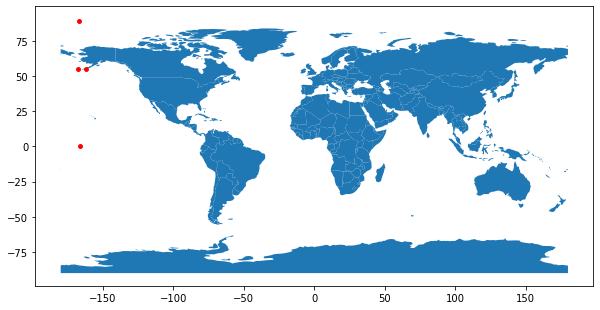

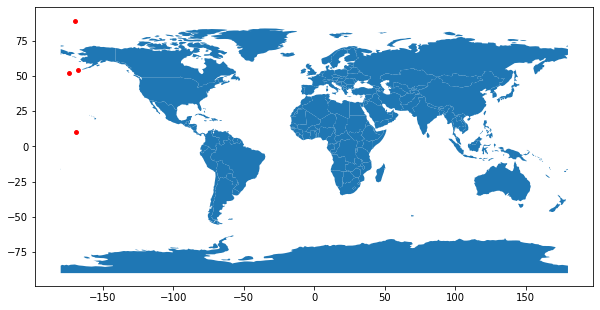

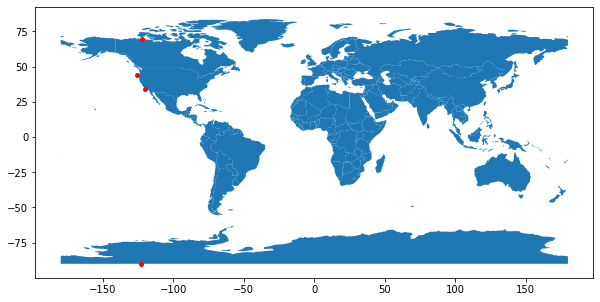

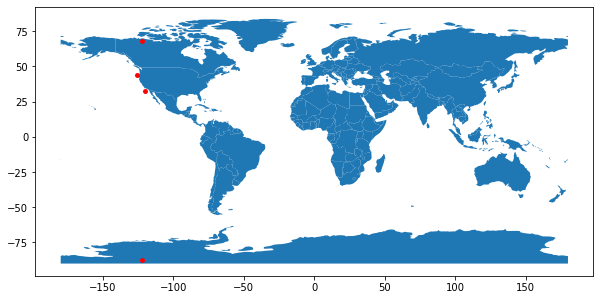

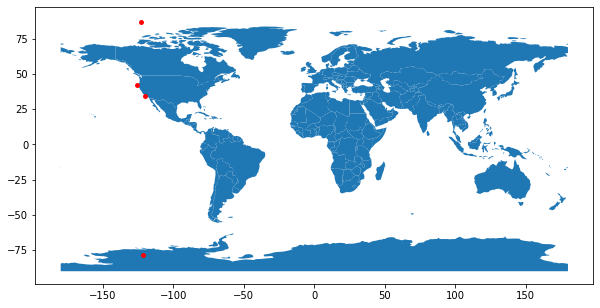

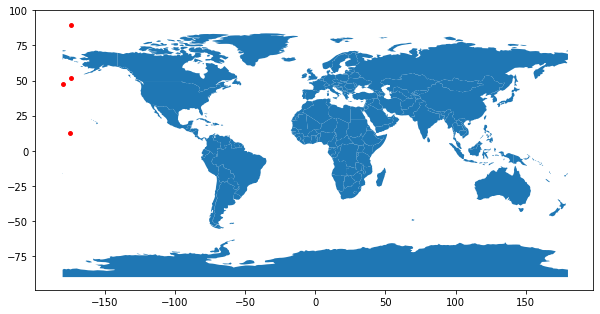

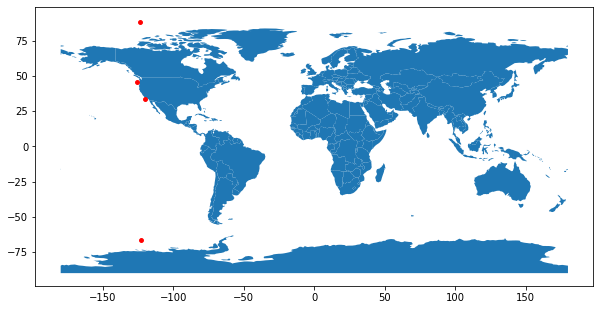

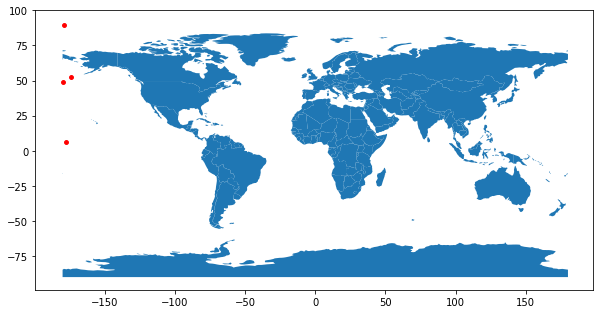

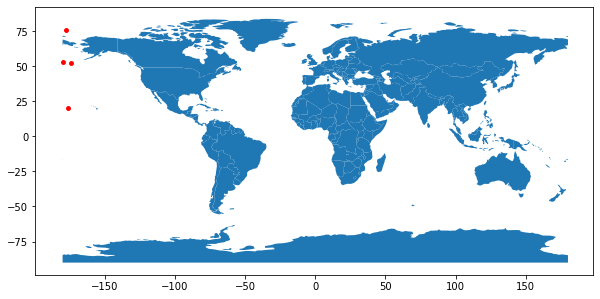

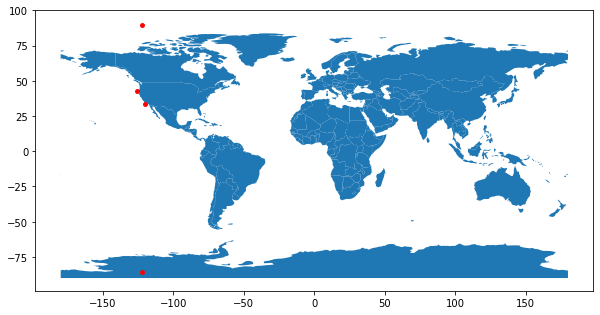

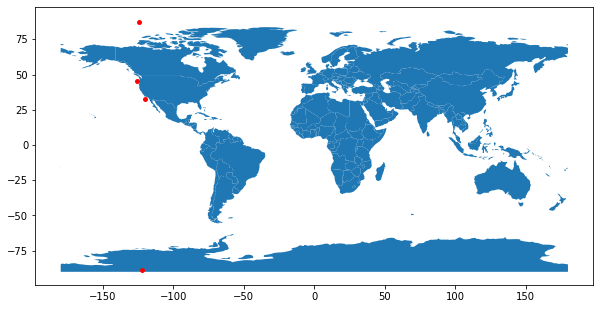

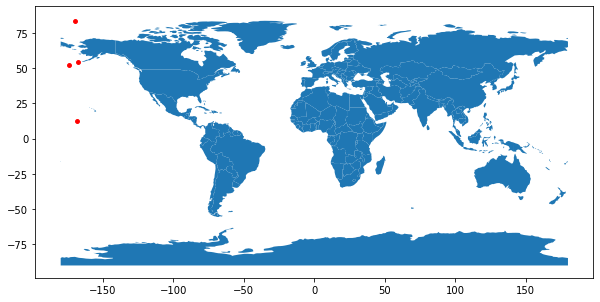

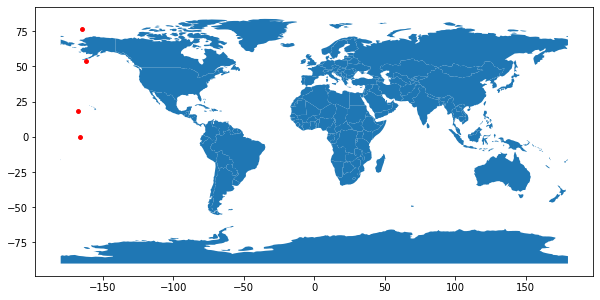

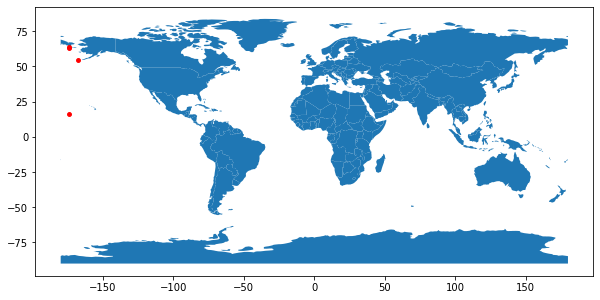

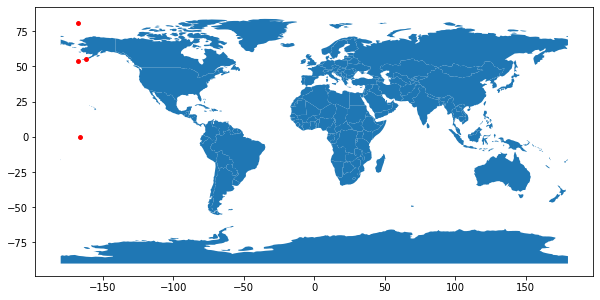

In [13]:
# Plotting boundary coordinates to visually identify Lat/Long anomally
count = 0
for folder in glob(WorkingFolder + "*/"):
    data_array = list()
#     #******** Temp hack
#     folder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/Zone02_2017_01/"
#     #************
    
    print(folder)
    Broadcast = pd.read_csv(folder + "Broadcast.csv", sep=",")
    
    print("Rows:", len(Broadcast))
    
    # Fetch Lat extreme values
    Broadcast = Broadcast.sort_values(by=['lat'], ascending=True)  # Sort by Lat
    temp = Broadcast.head(1)     # get lowest value
    data_array.append(temp[['lat', 'lon']].values[0])
    temp = Broadcast.tail(1)     # get highest value
    data_array.append(temp[['lat', 'lon']].values[0])
    
    # Fetch Lon extreme values
    Broadcast = Broadcast.sort_values(by=['lon'], ascending=True)  # Sort by Lon
    temp = Broadcast.head(1)     # get lowest value
    data_array.append(temp[['lat', 'lon']].values[0])
    temp = Broadcast.tail(1)     # get highest value
    data_array.append(temp[['lat', 'lon']].values[0])
    
    # df of lat/lon pairs
    df = pd.DataFrame(data_array, columns=['Latitude', 'Longitude'])
    
    # Plotting interested boundary coordinates
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)   

    #this is a simple map that goes with geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

#     count += 1
#     if count > 4: 
#         break
    


In [6]:
Broadcast.head()

,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
14739662,366050800,2014/01/19 23:03:05,42.370213,-126.00000,15.1,178.39999,10553,177,0
14397328,366050800,2014/01/19 12:45:54,44.957890,-126.00000,15.0,180.60001,10553,178,0
14426442,366050800,2014/01/19 13:07:17,44.869218,-126.00000,14.8,178.70000,10553,178,0
14546779,366050800,2014/01/19 17:00:05,43.907422,-126.00000,15.3,179.60001,10553,179,0
14547804,366050800,2014/01/19 17:39:47,43.739725,-125.99999,15.0,179.39999,10553,176,0


In [7]:
sample = Broadcast[['lat', 'lon']].drop_duplicates()
sample.shape

(13392752, 2)

In [8]:
sample['lat'] = sample['lat'].map(lambda x: round(x, 3))
sample['lon'] = sample['lon'].map(lambda x: round(x, 3))
sample.drop_duplicates(inplace=True)
sample.shape

(2675294, 2)

In [9]:
sample.head()

,lat,lon
14739662,42.370,-126.0
14397328,44.958,-126.0
14426442,44.869,-126.0
14546779,43.907,-126.0
14547804,43.740,-126.0


In [10]:
# Plotting interested boundary coordinates
geometry = [Point(xy) for xy in zip(sample['lon'], sample['lat'])]
gdf = GeoDataFrame(sample, geometry=geometry) 

In [11]:
sample.head()

,lat,lon,geometry
14739662,42.370,-126.0,POINT (-126.00000 42.37000)
14397328,44.958,-126.0,POINT (-126.00000 44.95800)
14426442,44.869,-126.0,POINT (-126.00000 44.86900)
14546779,43.907,-126.0,POINT (-126.00000 43.90700)
14547804,43.740,-126.0,POINT (-126.00000 43.74000)


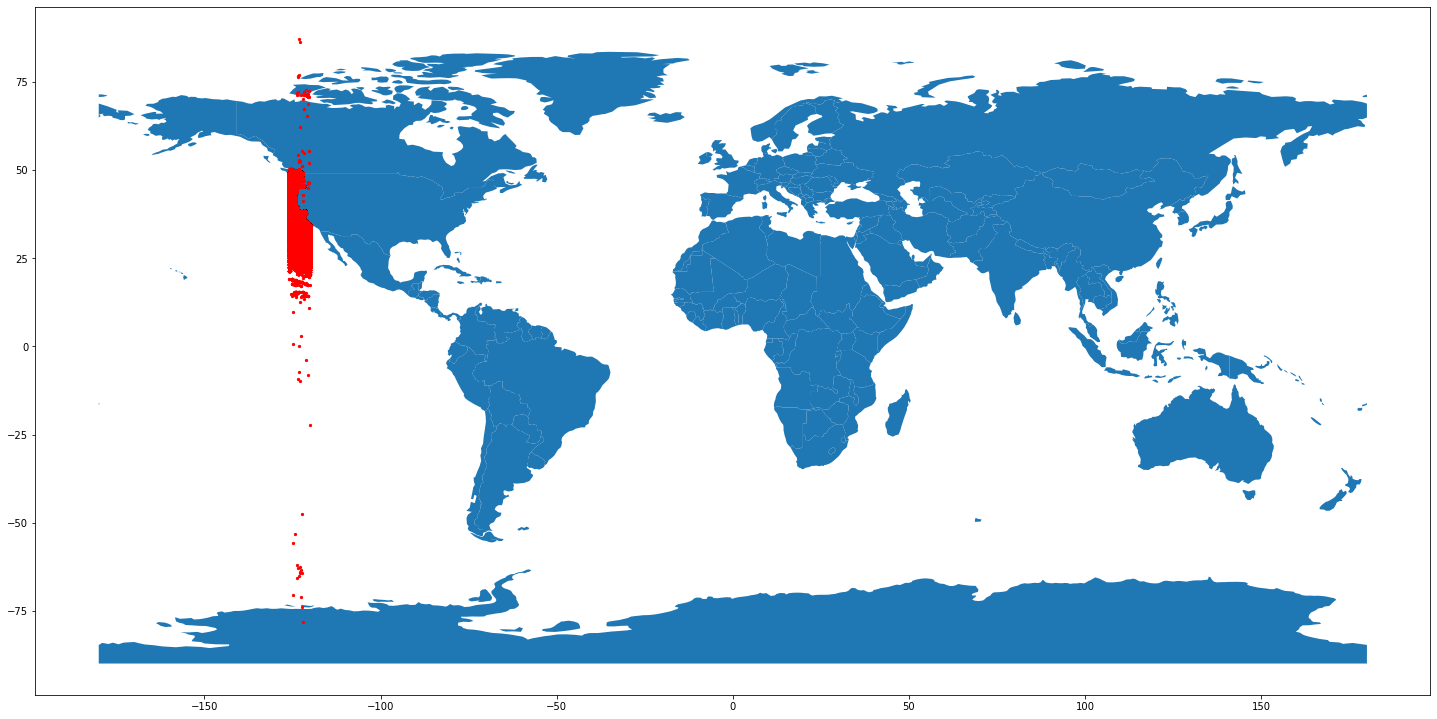

In [12]:
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(25, 30)), marker='o', color='red', markersize=5);

### Validate Voyage Data

In [4]:
# # Fetch valid Vessel data
# Vessel = pd.read_csv("/Users/cv0361/Desktop/TechChallenge/Data/csv/ValidAIS/Valid_Vessels.csv", sep=",")
# Vessel.head()

,mmsi_id,imo,call_sign,vessel_name,vessel_type,length,width,TempId,Id_len,StartDigit
0,303159000,IMO8315724,WAP2210,ARCTURUS,1001.0,39.93,9.76,303159000,9,3
1,367011410,IMO8856510,WAJ6882,KUSTATAN,1001.0,26.76,8.53,367011410,9,3
2,366499000,IMO6931055,WASF,KATIE ANN,1001.0,89.92,13.52,366499000,9,3
3,367528690,IMO7742358,WDG3692,ALASKAN LADY,1001.0,51.08,9.76,367528690,9,3
4,371542000,IMO8714944,3FSS6,NO1 POHAH,70.0,115.00,16.00,371542000,9,3


In [54]:
outputfile = OutputDir + "Voyage_Zone10_2014_01.csv"

# Fetch Voyage Data
Voyage = pd.read_csv(WorkingFolder + "Zone10_2014_01/Voyage.csv", sep=",")
Voyage.head()

,mmsi_id,voyage_id,draft,cargo
0,235469970,337,120,71
1,367870800,232,45,32
2,576110500,113,93,70
3,316004579,306,32,52
4,477221200,519,70,70


In [55]:
# Purge any Voyage entry from Invalid MMSI
Voyage = Voyage.loc[Voyage.mmsi_id.isin(Vessel.mmsi_id)]

Voyage = Voyage.drop_duplicates()   # Make sure no dup

print(outputfile)
print("Rows:", Voyage.shape[0])
print("After Invalid MMSI Purge:", Voyage.shape[0])

/Users/cv0361/Desktop/TechChallenge/Data/csv/ValidAIS/Voyage_Zone10_2014_01.csv
Rows: 15825
After Invalid MMSI Purge: 15825


In [56]:
# Save valid Broadcast to csv
Voyage.to_csv(outputfile, index=False)

### Combine Voyage Yearly

In [75]:
outputfile = "/Users/cv0361/Desktop/TechChallenge/Data/csv/ConsolidatedAIS/Voyage_2017.csv"
print(outputfile)
VoyageList = list()

# Fetch Voyage Data for all zone in a year
VoyageList.append(pd.read_csv("data/vessel data/ValidAIS/Voyage_Zone01_2017_01.csv", sep=","))
VoyageList.append(pd.read_csv("data/vessel data/ValidAIS/Voyage_Zone02_2017_01.csv", sep=","))
VoyageList.append(pd.read_csv("data/vessel data/ValidAIS/Voyage_Zone03_2017_01.csv", sep=","))

Voyage = pd.concat(VoyageList, ignore_index=True)

print("Combined Rows:", Voyage.shape[0])

Voyage.head()

/Users/cv0361/Desktop/TechChallenge/Data/csv/ConsolidatedAIS/Voyage_2017.csv
Combined Rows: 1307


,mmsi_id,voyage_id,draft,cargo
0,366940480,NaN,4.0,31.0
1,477444700,NaN,10.5,70.0
2,370024000,NaN,10.0,70.0
3,273898000,NaN,6.0,30.0
4,477027500,NaN,NaN,NaN


In [76]:
Voyage = Voyage.drop_duplicates()   # Make sure no dup
print("After Removed Dup:", Voyage.shape[0])

After Removed Dup: 866


In [77]:
Voyage = Voyage.drop_duplicates(['mmsi_id', 'voyage_id'])   # Make sure no dup
print("After Removed mmsi_id, voyage_id Dup:", Voyage.shape[0])

After Removed mmsi_id, voyage_id Dup: 859


In [78]:
# Save valid Broadcast to csv
Voyage.to_csv(outputfile, index=False)

### Combine Broadcast Yearly

In [85]:
outputfile = "data/vessel data/ConsolidatedAIS/Broadcast_2015.csv"
print(outputfile)
BroadcastList = list()

# Fetch Voyage Data for all zone in a year
BroadcastList.append(pd.read_csv("data/vessel data/ValidAIS/Broadcast_Zone01_2015_01.csv", sep=","))
BroadcastList.append(pd.read_csv("data/vessel data/ValidAIS/Broadcast_Zone02_2015_01.csv", sep=","))
BroadcastList.append(pd.read_csv("data/vessel data/ValidAIS/Broadcast_Zone03_2015_01.csv", sep=","))

Broadcast = pd.concat(BroadcastList, ignore_index=True)

print("Combined Rows:", Broadcast.shape[0])

Broadcast.head()

/Users/cv0361/Desktop/TechChallenge/Data/csv/ConsolidatedAIS/Broadcast_2015.csv
Combined Rows: 3180990


,mmsi_id,date_time,lat,lon,speed_over_ground,course_over_ground,voyage_id,heading,status
0,235091871,2015-01-01T00:08:26,52.78763,-175.62761,10.3,74.5,NaN,86.0,under way using engine
1,247119100,2015-01-01T05:36:17,52.87994,-176.21738,10.7,-148.8,NaN,263.0,under way using engine
2,247119100,2015-01-01T06:28:57,52.83234,-176.46662,11.0,-160.8,NaN,254.0,under way using engine
3,247119100,2015-01-01T06:32:27,52.82851,-176.48291,11.0,-160.6,NaN,254.0,under way using engine
4,247119100,2015-01-01T06:36:07,52.82446,-176.50022,11.0,-160.0,NaN,254.0,under way using engine


In [86]:
Broadcast = Broadcast.drop_duplicates()   # Make sure no dup
print("After Removed Dup:", Broadcast.shape[0])

After Removed Dup: 3143096


In [87]:
# Save valid Broadcast to csv
Broadcast.to_csv(outputfile, index=False)